# Computer Vision - Semester 8

## One step metric rectification mini-project - Exercise 3.6

     Dimitris Dimos - 031 17 165
     
#### Athens, 2021

The following code implements a one-step algorithm that removes the projective and affine distortions of an image that is known in advance. We manually select 5 pairs of lines (whice are depicted below) on the image for calculational purposes.
***

In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

The input image, on which we will apply the rectification algorithm, is shown below:

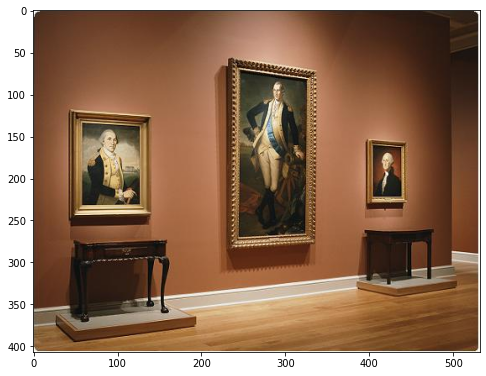

In [2]:
img = cv2.imread('/Users/dimitrisdimos/Desktop/paintings.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rcParams['figure.figsize'] = 8,8
_ = plt.imshow(img)

Initially, we choose 5 pairs of lines that are perpendicular _in the real world_.

In [3]:
# draws a pair of perpendicular lines and returns the lines in homogenous coordinates
def draw_perp_lines (img, pair, color):
    x1, y1 = pair[0][0], pair[0][1]
    x2, y2 = pair[1][0], pair[1][1]
    l = np.cross([x1, y1, 1], [x2, y2, 1])
    cv2.line(img, (x1, y1), (x2, y2), color, thickness=2)

    x1, y1 = pair[2][0], pair[2][1]
    x2, y2 = pair[3][0], pair[3][1]
    m = np.cross([x1, y1, 1], [x2, y2, 1])
    cv2.line(img, (x1, y1), (x2, y2), color, thickness=2)
    
    return (l, m)

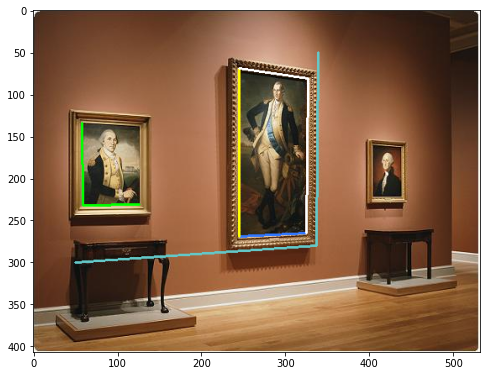

In [4]:
# read input image
lines_image = cv2.imread('/Users/dimitrisdimos/Desktop/paintings.jpg')
lines_image = cv2.cvtColor(lines_image, cv2.COLOR_BGR2RGB)

colors = dict()
colors['ciel']   = (100,200,200)
colors['green']  = (0, 255, 0)
colors['white']  = (255,255,255)
colors['yellow'] = (255,255,0)
colors['blue']   = (50,120,255)
line_colors = ['ciel', 'green', 'blue', 'yellow', 'white']

# each row has a pair of perpendicular lines
points = [[(50,300),(337,280),(339,50),(337,280)],
          [(126,231),(59,232),(59,232),(58,134)],
          [(327,81),(325,265),(325,265),(245,269)],
          [(245,269),(245,69),(245,69),(327,81)],
          [(245,69),(327,81),(327,81),(325,265)]]

pairs_of_lines = []
for i in range(5):
    l, m = draw_perp_lines(lines_image, points[i], colors[line_colors[i]])
    pairs_of_lines.append((l,m))

_ = plt.imshow(lines_image)
_ = cv2.imwrite('/Users/dimitrisdimos/Desktop/lines.png',img)

Each pair of lines has a unique color. We can only see one blue and one yellow line. Their other perpendicular line has been covered by the two white lines.

In [5]:
# unfold the lines
l1, m1 = pairs_of_lines[0]
l2, m2 = pairs_of_lines[1]
l3, m3 = pairs_of_lines[2]
l4, m4 = pairs_of_lines[3]
l5, m5 = pairs_of_lines[4]

Now that we have the line pairs, we can calculate an approximation of the C'.

In [6]:
'''
Description: Calculates the parameters a, b, c, d, e (f = 1) of C' (image of the dual conic C)
             
Usage: c = calculate_conic(pair1, pair2, pair3, pair4, pair5)
             
In:  5 pairs of perpendicular lines
Out: the parameters of C' (c vector, without the f parameter)
'''
def calculate_conic(pair1, pair2, pair3, pair4, pair5):
    
    # unfold input pairs
    l1, m1 = pair1
    l2, m2 = pair2
    l3, m3 = pair3
    l4, m4 = pair4
    l5, m5 = pair5
    
    # unfold line coordinates
    l11, l12, l13 = l1
    l21, l22, l23 = l2
    l31, l32, l33 = l3
    l41, l42, l43 = l4
    l51, l52, l53 = l5
    
    m11, m12, m13 = m1
    m21, m22, m23 = m2
    m31, m32, m33 = m3
    m41, m42, m43 = m4
    m51, m52, m53 = m5
    
    # construct the linear system
    A = np.array([[l11*m11, 1/2*(l11*m12+l12*m11), l12*m12, 1/2*(l11*m13+l13*m11), 1/2*(l12*m13+l13*m12)],
                  [l21*m21, 1/2*(l21*m22+l22*m21), l22*m22, 1/2*(l21*m23+l23*m21), 1/2*(l22*m23+l23*m22)],
                  [l31*m31, 1/2*(l31*m32+l32*m31), l32*m32, 1/2*(l31*m33+l33*m31), 1/2*(l32*m33+l33*m32)],
                  [l41*m41, 1/2*(l41*m42+l42*m41), l42*m42, 1/2*(l41*m43+l43*m41), 1/2*(l42*m43+l43*m42)],
                  [l51*m51, 1/2*(l51*m52+l52*m51), l52*m52, 1/2*(l51*m53+l53*m51), 1/2*(l52*m53+l53*m52)]])
    
    b = np.array([[-l13*m13],
                  [-l23*m23],
                  [-l33*m33],
                  [-l43*m43],
                  [-l53*m53]])
    
    # solve the linear system
    c = np.linalg.solve(A, b)
    return c    

In [7]:
C = calculate_conic((l1,m1), (l2,m2), (l3,m3), (l4,m4), (l5,m5))
normalize = np.amax(C)
C = C/normalize

a = C[0][0]
b = C[1][0]
c = C[2][0]
d = C[3][0]
e = C[4][0]
f = 1/normalize

print('C = \n{}\n'.format(np.array([[a, b/2, d/2],
                                    [b/2, c, e/2],
                                    [d/2, e/2, f]])))
print('a = {}'.format(a))
print('b = {}'.format(b))
print('c = {}'.format(c))
print('d = {}'.format(d))
print('e = {}'.format(e))
print('f = {}'.format(f))

C = 
[[1.00000000e+00 1.94400605e-01 8.64004441e-04]
 [1.94400605e-01 6.40680165e-01 2.35803942e-04]
 [8.64004441e-04 2.35803942e-04 9.07994414e-07]]

a = 1.0
b = 0.38880121096791426
c = 0.6406801653838397
d = 0.0017280088820803951
e = 0.0004716078840747384
f = 9.079944135624021e-07


After calculating the $C_{\infty}^*$ matrix, we devide each element (normalization) with the maximum value of $C_{\infty}^*$, with no change in the result, as this division does not affect the ratios between each pair of elements. 

At next, we will match the $C_{\infty}^*$ matrix that we calculated to the form of equation (2.23) of H-Z.

$$C^*_{\infty} =
\begin{bmatrix}
a & b/2 & d/2 \\
b/2 & c & e/2 \\
d/2 & e/2 & f
\end{bmatrix} \longleftrightarrow
\begin{bmatrix}
KK^\top & KK^\top \mathbf{v} \\
\mathbf{v^\top}KK^\top & \mathbf{v^\top}KK^\top\mathbf{v}
\end{bmatrix}
$$,

where $K$ is a $(2 \times 2)$ upper-triangular matrix normalized as $det(K) = 1$ and $v$ is a $(2\times 1)$ vector:

$$K = \begin{bmatrix}K_{11} & K_{12} \\ 0 & K_{22}\end{bmatrix} \text{ and } \; 
\mathbf{v} = \begin{bmatrix}v_{1} & v_{2}\end{bmatrix}$$

We desire the determinant of K to be equal to unity.

We now proceed to calculations:

$$
KK^\top =
\begin{bmatrix}
K_{11}^2+K_{12}^2 & K_{12}\cdot K_{22} \\
K_{12}\cdot K_{22} & K_{22}^2
\end{bmatrix}
=
\begin{bmatrix}
a & b/2 \\
b/2 & c
\end{bmatrix}
\implies
\begin{equation*}
    \left\{
        \begin{array}\\
            K_{11}^2+K_{12}^2=a \\
            K_{12}\cdot K_{22}=b/2 \\
            K_{22}^2=c
        \end{array}
    \right.
\end{equation*}
$$

In order to calculate the $K$ matrix, we have two obvious options. The first one is solving the non-linear equations of the matching between the $C_{\infty}^{*}$ and $KK^{\top}$ as they are stated above. The other one involves the Cholesky Decomposition method, but in order to use it we first need to prove the necessary properties of the matrices involved. It is relatively easy to prove the properties, but we can save valuable time just by calculating the result solving the equations above. Therefore:

$$\begin{array}\\
    K_{11}^2+K_{12}^2=a \\
    K_{12}\cdot K_{22}=b/2 \\
    K_{22}^2=c
\end{array} \implies
\left\{
    \begin{array}\\
        K_{11}=\pm \sqrt{a-\frac{b^2}{4c}} \\
        K_{12}=\pm \frac{b}{2\sqrt{c}} \\
        K_{22}=\pm \sqrt{c}
    \end{array}
\right.
$$

It is easy to observe that $K_{12}$ and $K_{22}$ must have the same sign. Furthermore, we would like to have $det(K) = 1 > 0$ meaning that $K_{11}K_{22}>0$, hence $K_{11}$ and $K_{22}$ will also have the same sign. This results in all $K_{11}, K_{12}$ and $K_{22}$ having the same sign. We assume positive sign for our calculations. If we are proven wrong, we will just lift the assumption and consider negative signs.

$$K = \begin{bmatrix}\sqrt{a-\frac{b^2}{4c}} & \frac{b}{2\sqrt{c}} \\ 0 & \sqrt{c}\end{bmatrix}$$

We continue with the second matching:

$$
KK^\top\mathbf{v} =
\begin{bmatrix}
(K_{11}^2+K_{12}^2)v_1 + K_{12}K_{22}v_2 \\
K_{12}K_{22}v_1 + K_{22}^2v_2
\end{bmatrix}
=
\begin{bmatrix}
d/2 \\
e/2
\end{bmatrix}
\implies
\left\{
    \begin{array}\\
        av_1 + \frac{b}{2}v_2 = d/2\\
        \frac{b}{2}v_1 + cv_2 = e/2
    \end{array}
\right.
\implies
\left\{
    \begin{array}\\
        v_1 = \frac{-2cd+be}{b^2-4ac}\\
        v_2 = \frac{bd-2ae}{b^2-4ac}
    \end{array}
\right.
$$

It is safe to say that $b^2-4ac \neq 0$, because otherwise $K_{11} = 0\implies$ $K$: singular.

At this point, there is one last thing we need to point out, before continuing with the practical calculations of K and v. It is almost certain that the manual choice of lines on the input image will lead to an approximate result, meaning that K will most probably not have $det(K)=1$. This is something we can overcome though.

If we arrive at a point where $0 < det(K) = q < 1$, it is completely safe to divide all elements of K by $\sqrt{det(K)}$ in order to manipulate the determinant into becoming 1. Here is the proof:

Suppose we multiply $K$ by $q$ (for us $q=1/det(K)$) and that the transformation applied on the image can be decomposed into $H_SH_AH_P$, where $H_S$ does not affect the removal of affine and projective distortions in any way. $H_A$ can be written as:

$$
H_{A} =
\begin{bmatrix}
K & \mathbf{0} \\
\mathbf{0}^\top & 1
\end{bmatrix}
=
\underbrace{
    \begin{bmatrix}
    1/q\cdot\bf{I} & \mathbf{0} \\
    \mathbf{0}^\top & 1
    \end{bmatrix}
}_{H_S'}
\cdot
\underbrace{
    \begin{bmatrix}
    qK & \mathbf{0} \\
    \mathbf{0}^\top & 1
    \end{bmatrix}
}_{H_A'}
$$

and we can now consider that the $H_S$ part of the projection transform can be divided into two matrices, the second of which is the above $H_S'$. This way, we force $K$ to have unit determinant with no error in the metric rectification. The $H_S'$ can safely be ignored, as the similarity transformation will concern us in the end.

In [8]:
# Manual calculation of K
K11 = math.sqrt(a-b**2/(4*c))
K12 = b/(2*math.sqrt(c))
K21 = 0
K22 = math.sqrt(c)

K = np.array([[K11, K12],
              [K21, K22]])

"""
# Cholesky decomposition 
C = np.array([[a  , b/2, d/2],
              [b/2, c  , e/2],
              [d/2, e/2, f  ]])

K = np.linalg.cholesky(C[:2,:2]).transpose()
"""

detK = np.linalg.det(K)
print('det(K) = {}'.format(detK))

det(K) = 0.7764589943914041


In [9]:
# normalization of K
q = 1/math.sqrt(detK)
K = q*K

detK_new = np.linalg.det(K)
print('The new determinant is det(K) = {}'.format(round(detK_new)))

The new determinant is det(K) = 1


We now calculate the vector v:

In [10]:
'''
# Using numpy system solver
A = C[:2,:2]
b = np.array([[d/2],
              [e/2]])
v = np.linalg.solve(A, b)
'''

# Manually calculating the result
v1 = (-2*c*d+b*e)/(b**2-4*a*c)
v2 = (b*d-2*a*e)/(b**2-4*a*c)
v = np.array([[v1],
              [v2]])

In [11]:
print('The resulting K matrix and v vector are:\n\nK =\n{}\n\nv =\n{}'.format(K, v))

The resulting K matrix and v vector are:

K =
[[1.10087656 0.27562443]
 [0.         0.90836706]]

v =
[[0.00084213]
 [0.00011253]]


If we now stop our study here and just apply the results on our input image in order to metrically rectify it, we will receive the following results:

$$
I_{rectified} = H^{-1}I_{input} = (H_PH_A)^{-1}I_{input}
$$

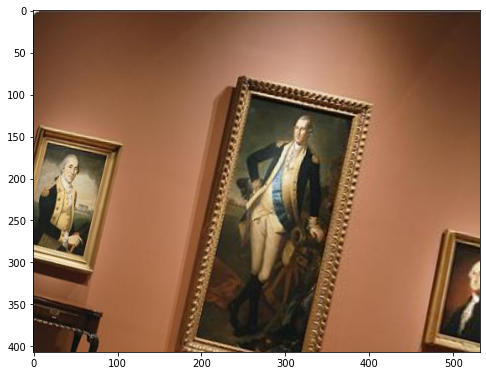

In [12]:
H_A = np.array([[K[0][0], K[0][1], 0],
                [K[1][0], K[1][1], 0],
                [0      , 0      , 1]])

H_P = np.array([[1   , 0   , 0],
                [0   , 1   , 0],
                [v[0][0], v[1][0], 1]])

H = np.matmul(H_P, H_A)
Hinv = np.linalg.inv(H)

im_out = cv2.warpPerspective(img, Hinv, (img.shape[1],img.shape[0]))
_ = plt.imshow(im_out)

The result is not satisfactory, but if we look closely the affine and projective distortions seem to have been reduced (if not removed completely). The reason why this result is still not good enough is that through our algorithm we have not cared for similarity distortions. This is going to be our last move.

$$
I_{rectified} = H^{-1}I_{input} = (H_PH_AH_S)^{-1}I_{input}
$$

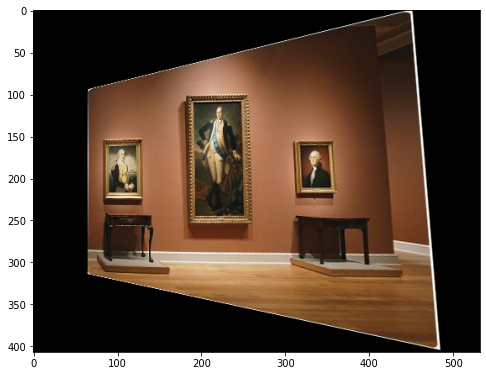

In [13]:
s = 2.2
theta = np.pi/13
tx = -90
ty = -235
H_S = np.array([[s*np.cos(theta), -s*np.sin(theta), tx],
                [s*np.sin(theta), s*np.cos(theta) , ty],
                [0              , 0               , 1 ]])

H = np.matmul(H, H_S)
Hinv = np.linalg.inv(H)

im_out = cv2.warpPerspective(img, Hinv, (img.shape[1],img.shape[0]))
_ = plt.imshow(im_out)

This is the final result. It is quite obvious that the rectified image is not perfect. But there are some good reasons why this is the case:

- First of all, the input image has been taken from the side _at the very beginning_. It was not taken from the front and _then distorted_, which means that the result can never be as good as taking the picture en face. The sideways info (eg the fact that the back legs of the tables do not hide behind the front legs) cannot be removed completely.

- Second, the very choice of the lines at the first step of the algorithm leads to completely different results. Having tried many combinations of line-pairs, we have concluded that some of them lead to different results than the one shown above. Some choices even lead to _negative_ **c** parameter of the $C_{\infty}^{*}$

- The similarity transform that we used in the end to - let's say - beautify the result has been computed manually by making attempts and examining the result. Finally, it has the form:

$$
H_S = 
\begin{bmatrix}
2.2\cdot cos(\frac{\pi}{13}) & -2.2\cdot sin(\frac{\pi}{13}) & -90\\
2.2\cdot sin(\frac{\pi}{13}) & 2.2\cdot cos(\frac{\pi}{13}) & -235\\
0 & 0 & 1
\end{bmatrix}
$$

The application of this $H_S$ is equal to turning $K$ into: $K' = sRK + \bf{t}v^\top$, which in fact is the general form of the $A = (H_PH_AH_S)[:2,:2]$ submatrix.